In [1]:
import numpy as np
import la_forge.core as co
import pickle, json, copy
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
from enterprise import constants as const

from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic as OS

You'll need sksparse for get_coefficients() with common signals!


In [2]:
pkl = '/Users/hazboun/ipta/ipta_dr2_classic_de436.pkl'
with open(pkl,'rb')as fin:
    psrs = pickle.load(fin)

In [18]:
rm_idxs = []
for idx, p in enumerate(psrs):
    first = p.toas.min()
    last = p.toas.max()
    tspan = (last - first)/(365.25*24*3600)
    if tspan<3.0:
        rm_idxs.append(idx)
#     print(p.name, f'{tspan:2.1f}')

for idx in reversed(rm_idxs):
    del psrs[idx]

In [19]:
tmin = np.amin([p.toas.min() for p in psrs])
tmax = np.amax([p.toas.max() for p in psrs])
Tspan = tmax - tmin
Tspan/(365.25*24*3600)

30.190711132332584

In [42]:
# Red noise parameter priors
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# DM Red noise parameter priors
dm_log10_A = parameter.Uniform(-20, -11)
dm_gamma = parameter.Uniform(0, 7)

# GW parameter priors
gw_log10_A = parameter.Uniform(-18, -14)('gw_log10_A')
gw_gamma = parameter.Constant(13./3)('gw_gamma')

# White noise parameter priors
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

freqs = np.linspace(1/Tspan,30/Tspan,30)

In [43]:
# # white noise
selection_ng = selections.Selection(selections.nanograv_backends)
selection_be = selections.Selection(selections.by_backend)

ef = white_signals.MeasurementNoise(efac=efac, selection=selection_be)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection_be)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection_ng)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, modes=freqs)#components=30,Tspan=Tspan)

# DM red noise (powerlaw with 30 frequencies)
dm_basis = utils.createfourierdesignmatrix_dm(modes=freqs)
dm_pl = utils.powerlaw(log10_A=dm_log10_A, gamma=dm_gamma)
dm_gp = gp_signals.BasisGP(priorFunction=dm_pl, basisFunction=dm_basis, name='dm_gp')#components=30,Tspan=Tspan)

# gw (powerlaw with 10 frequencies)

gw_pl = utils.powerlaw(log10_A=gw_log10_A, gamma=gw_gamma)
gw = gp_signals.FourierBasisGP(spectrum=gw_pl, modes=freqs[:10], name='gw')#components=5, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel()

In [44]:
model = tm + ef + eq + rn + dm_gp + gw 
model_ng = model + ec 

In [45]:
models = [model_ng(p) if 'NANOGrav' in p.flags['pta'] else model(p) for p in psrs]

In [46]:
pta = signal_base.PTA(models)

In [24]:
noise_path = '/Users/hazboun/ipta/classic_fixed/dr2_classic_noise.json'

In [25]:
with open(noise_path,'r') as fin:
    noise = json.load(fin)

In [47]:
pta.set_default_params(noise)

INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.1365193945368486
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.9799469185765327
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.1360_efac to 1.1131774722050722
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.1410_efac to 0.7317297647944114
INFO: enterprise.signals.signal_base: Setting J0030+0451_EFF.EBPP.2639_efac to 0.9816169162003063
INFO: enterprise.signals.signal_base: Setting J0030+0451_JBO.DFB.1520_efac to 1.0323718949754754
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.1237984445609916
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.1395353301435847
INFO: enterprise.signals.signal_base: Setting J0030+0451_NRT.BON.1400_efac to 1.1918353704710902
INFO: enterprise.signals.signal_base: Setting J0030+0451_NRT.BON.1600_efac to 1.5756952974884049
INFO: enterprise.signals.signal_base:

INFO: enterprise.signals.signal_base: Setting J0437-4715_PDFB_40CM_log10_equad to -7.503948141950352
INFO: enterprise.signals.signal_base: Setting J0437-4715_PDFB_50CM_log10_equad to -6.597137744772705
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.cpsr1.20cm_legacy_log10_equad to -6.956485100190424
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.cpsr2.20cm_legacy_log10_equad to -8.023662046871959
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.fptm.20cm-legacy_log10_equad to -6.425095378224767
INFO: enterprise.signals.signal_base: Setting J0437-4715_PKS.s2.20cm-legacy_log10_equad to -7.037802919641953
INFO: enterprise.signals.signal_base: Setting J0437-4715_WBCORR_10CM_log10_equad to -6.416938872758119
INFO: enterprise.signals.signal_base: Setting J0437-4715_WBCORR_20CM_log10_equad to -7.352602899412229
INFO: enterprise.signals.signal_base: Setting J0610-2100_JBO.DFB.1520_efac to 0.9561319405297859
INFO: enterprise.signals.signal_base: Setting J

INFO: enterprise.signals.signal_base: Setting J0621+1002_WSRT.P1.323.C_efac to 2.0634563476909142
INFO: enterprise.signals.signal_base: Setting J0621+1002_WSRT.P1.367.C_efac to 1.60570617347227
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.1360_log10_equad to -6.840229027469453
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.1410_log10_equad to -6.4136234859371495
INFO: enterprise.signals.signal_base: Setting J0621+1002_EFF.EBPP.2639_log10_equad to -6.741095969763628
INFO: enterprise.signals.signal_base: Setting J0621+1002_JBO.DFB.1400_log10_equad to -6.523470787480318
INFO: enterprise.signals.signal_base: Setting J0621+1002_JBO.DFB.1520_log10_equad to -7.046538643744288
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.1400_log10_equad to -7.084852706049046
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.1600_log10_equad to -6.789299166376719
INFO: enterprise.signals.signal_base: Setting J0621+1002_NRT.BON.2000_log1

INFO: enterprise.signals.signal_base: Setting J1012+5307_EFF.EBPP.2639_log10_equad to -7.1968778908834246
INFO: enterprise.signals.signal_base: Setting J1012+5307_JBO.DFB.1400_log10_equad to -7.31409009426702
INFO: enterprise.signals.signal_base: Setting J1012+5307_JBO.DFB.1520_log10_equad to -6.072720916928635
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.1400_log10_equad to -6.433160064221364
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.1600_log10_equad to -6.023914215850753
INFO: enterprise.signals.signal_base: Setting J1012+5307_NRT.BON.2000_log10_equad to -7.028164319799292
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr1_2_GASP_log10_equad to -7.420332253841796
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr1_2_GUPPI_log10_equad to -6.404566251351747
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr_800_GASP_log10_equad to -7.112374879793455
INFO: enterprise.signals.signal_base: Setting J1012+5307_Rcvr

INFO: enterprise.signals.signal_base: Setting J1024-0719_EFF.EBPP.2639_log10_equad to -6.830146063004504
INFO: enterprise.signals.signal_base: Setting J1024-0719_JBO.DFB.1400_log10_equad to -7.185930655361004
INFO: enterprise.signals.signal_base: Setting J1024-0719_JBO.DFB.1520_log10_equad to -7.284536848244275
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.1400_log10_equad to -7.517672194464818
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.1600_log10_equad to -6.019849933649348
INFO: enterprise.signals.signal_base: Setting J1024-0719_NRT.BON.2000_log10_equad to -6.742283245955423
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_10CM_log10_equad to -6.211439208875985
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_20CM_log10_equad to -7.488327749842836
INFO: enterprise.signals.signal_base: Setting J1024-0719_PDFB_40CM_log10_equad to -7.387638680458611
INFO: enterprise.signals.signal_base: Setting J1024-0719_PKS.AFB.20cm_le

INFO: enterprise.signals.signal_base: Setting J1600-3053_CPSR2_50CM_log10_equad to -6.8712723879603255
INFO: enterprise.signals.signal_base: Setting J1600-3053_JBO.DFB.1520_log10_equad to -7.398181119937567
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.1400_log10_equad to -7.736119597740007
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.1600_log10_equad to -7.450061145742775
INFO: enterprise.signals.signal_base: Setting J1600-3053_NRT.BON.2000_log10_equad to -7.369477917696796
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_10CM_log10_equad to -6.493686179607709
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_20CM_log10_equad to -7.622415096598089
INFO: enterprise.signals.signal_base: Setting J1600-3053_PDFB_40CM_log10_equad to -7.181179903982931
INFO: enterprise.signals.signal_base: Setting J1600-3053_PKS.AFB.20cm_legacy_log10_equad to -6.766880071785828
INFO: enterprise.signals.signal_base: Setting J1600-3053_PKS.cpsr2.

INFO: enterprise.signals.signal_base: Setting J1643-1224_CPSR2_50CM_efac to 1.3917000935025994
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.1360_efac to 1.122987773626916
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.1410_efac to 1.1937000433597678
INFO: enterprise.signals.signal_base: Setting J1643-1224_EFF.EBPP.2639_efac to 1.3109054407063507
INFO: enterprise.signals.signal_base: Setting J1643-1224_JBO.DFB.1400_efac to 0.9578585891117578
INFO: enterprise.signals.signal_base: Setting J1643-1224_JBO.DFB.1520_efac to 1.0084793120356768
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.1400_efac to 1.5761853193020579
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.1600_efac to 1.3655377541056362
INFO: enterprise.signals.signal_base: Setting J1643-1224_NRT.BON.2000_efac to 1.2235013328589914
INFO: enterprise.signals.signal_base: Setting J1643-1224_PDFB_10CM_efac to 1.164591315568989
INFO: enterprise.signals.signal_ba

INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.1380.2.C_efac to 0.5989190340012798
INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.2273.C_efac to 1.118330976698451
INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.840_efac to 0.8658809208608252
INFO: enterprise.signals.signal_base: Setting J1713+0747_WSRT.P1.840.C_efac to 0.9918646768000309
INFO: enterprise.signals.signal_base: Setting J1713+0747_CPSR2_20CM_log10_equad to -6.747656386350427
INFO: enterprise.signals.signal_base: Setting J1713+0747_CPSR2_50CM_log10_equad to -5.8603189030200955
INFO: enterprise.signals.signal_base: Setting J1713+0747_EFF.EBPP.1360_log10_equad to -6.116609001767319
INFO: enterprise.signals.signal_base: Setting J1713+0747_EFF.EBPP.1410_log10_equad to -6.404151630642765
INFO: enterprise.signals.signal_base: Setting J1713+0747_EFF.EBPP.2639_log10_equad to -6.683977263614992
INFO: enterprise.signals.signal_base: Setting J1713+0747_JBO.DFB.1400_log10_equad to -6

INFO: enterprise.signals.signal_base: Setting J1730-2304_EFF.EBPP.1410_log10_equad to -6.899254975893225
INFO: enterprise.signals.signal_base: Setting J1730-2304_EFF.EBPP.2639_log10_equad to -6.720439918092484
INFO: enterprise.signals.signal_base: Setting J1730-2304_JBO.DFB.1400_log10_equad to -6.588991251865204
INFO: enterprise.signals.signal_base: Setting J1730-2304_JBO.DFB.1520_log10_equad to -7.222693037454217
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.1400_log10_equad to -5.876955717865271
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.1600_log10_equad to -6.831540723154401
INFO: enterprise.signals.signal_base: Setting J1730-2304_NRT.BON.2000_log10_equad to -7.001844759932361
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_10CM_log10_equad to -7.026162878873915
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_20CM_log10_equad to -6.485617589925986
INFO: enterprise.signals.signal_base: Setting J1730-2304_PDFB_40CM_l

INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GUPPI_efac to 1.2168315741883666
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GASP_efac to 1.1905670408416267
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_efac to 1.0475008411750533
INFO: enterprise.signals.signal_base: Setting J1744-1134_WBCORR_10CM_efac to 1.1923717677950219
INFO: enterprise.signals.signal_base: Setting J1744-1134_WBCORR_20CM_efac to 6.457695506403045
INFO: enterprise.signals.signal_base: Setting J1744-1134_WSRT.P1.323.C_efac to 1.0206359420752187
INFO: enterprise.signals.signal_base: Setting J1744-1134_WSRT.P1.367.C_efac to 1.0637271807701387
INFO: enterprise.signals.signal_base: Setting J1744-1134_CPSR2_20CM_log10_equad to -6.201688175926256
INFO: enterprise.signals.signal_base: Setting J1744-1134_CPSR2_50CM_log10_equad to -6.014125001219935
INFO: enterprise.signals.signal_base: Setting J1744-1134_EFF.EBPP.1360_log10_equad to -6.101254115579169
INFO: ent

INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1600_efac to 1.0895547395711185
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380_efac to 1.116855639902787
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380.C_efac to 1.281649221698678
INFO: enterprise.signals.signal_base: Setting J1843-1113_JBO.DFB.1520_log10_equad to -5.222199931083017
INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1400_log10_equad to -7.320548713228348
INFO: enterprise.signals.signal_base: Setting J1843-1113_NRT.BON.1600_log10_equad to -7.142903948290848
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380_log10_equad to -6.906362600933003
INFO: enterprise.signals.signal_base: Setting J1843-1113_WSRT.P1.1380.C_log10_equad to -6.827547447390401
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_ASP_efac to 1.0720657812672434
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_PUPPI_efac to 1.0678006970906606
I

INFO: enterprise.signals.signal_base: Setting J1903+0327_L-wide_PUPPI_log10_ecorr to -5.957132167196923
INFO: enterprise.signals.signal_base: Setting J1903+0327_S-wide_ASP_log10_ecorr to -7.357913918666095
INFO: enterprise.signals.signal_base: Setting J1903+0327_S-wide_PUPPI_log10_ecorr to -7.19015845306828
INFO: enterprise.signals.signal_base: Setting J1909-3744_CPSR2_20CM_efac to 0.9957694403538463
INFO: enterprise.signals.signal_base: Setting J1909-3744_CPSR2_50CM_efac to 1.1219723851434589
INFO: enterprise.signals.signal_base: Setting J1909-3744_NRT.BON.1400_efac to 1.1798333674951174
INFO: enterprise.signals.signal_base: Setting J1909-3744_NRT.BON.1600_efac to 1.023265703025794
INFO: enterprise.signals.signal_base: Setting J1909-3744_NRT.BON.2000_efac to 1.1861310772650082
INFO: enterprise.signals.signal_base: Setting J1909-3744_PDFB_10CM_efac to 1.0948260186416898
INFO: enterprise.signals.signal_base: Setting J1909-3744_PDFB_20CM_efac to 1.2463951407243932
INFO: enterprise.signal

INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GASP_log10_equad to -7.654931517144057
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GUPPI_log10_equad to -7.407176956710728
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GASP_log10_equad to -6.88473127071273
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GUPPI_log10_equad to -7.5859732528755695
INFO: enterprise.signals.signal_base: Setting J1918-0642_WSRT.P1.1380_log10_equad to -7.317444681228515
INFO: enterprise.signals.signal_base: Setting J1918-0642_WSRT.P1.1380.C_log10_equad to -7.033965106496656
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GASP_log10_ecorr to -7.616785156591428
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr1_2_GUPPI_log10_ecorr to -6.708765011241715
INFO: enterprise.signals.signal_base: Setting J1918-0642_Rcvr_800_GASP_log10_ecorr to -6.566467342213459
INFO: enterprise.signals.signal_base: Setting J1918-0642

INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_efac to 1.2020082949244173
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_efac to 1.4053201642463713
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_efac to 1.3946160316471428
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_log10_equad to -7.157736975311375
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_log10_equad to -7.343291894241638
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_log10_equad to -7.287869228537538
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_log10_equad to -7.610918773791346
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_log10_ecorr to -6.195910697657067
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_log10_ecorr to -5.890083585252788
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_log10_ecorr to -6.121101387654186
INFO: 

INFO: enterprise.signals.signal_base: Setting J2124-3358_CPSR2_50CM_log10_equad to -6.707040282298372
INFO: enterprise.signals.signal_base: Setting J2124-3358_JBO.DFB.1400_log10_equad to -6.791797019607793
INFO: enterprise.signals.signal_base: Setting J2124-3358_JBO.DFB.1520_log10_equad to -6.6953406173648755
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.1400_log10_equad to -7.2437178075168
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.1600_log10_equad to -7.192639108571274
INFO: enterprise.signals.signal_base: Setting J2124-3358_NRT.BON.2000_log10_equad to -5.6955248904667375
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_10CM_log10_equad to -6.897402081072292
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_20CM_log10_equad to -7.408710234501136
INFO: enterprise.signals.signal_base: Setting J2124-3358_PDFB_40CM_log10_equad to -7.279849078800557
INFO: enterprise.signals.signal_base: Setting J2124-3358_PKS.AFB.20cm_legac

INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.2273.C_log10_equad to -6.725515164016669
INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.323.C_log10_equad to -6.624669363296452
INFO: enterprise.signals.signal_base: Setting J2145-0750_WSRT.P1.367.C_log10_equad to -5.3435965806883345
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr1_2_GASP_log10_ecorr to -5.7393856426104275
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr1_2_GUPPI_log10_ecorr to -6.398455780034647
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GASP_log10_ecorr to -5.754307689238351
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GUPPI_log10_ecorr to -5.8343604630483
INFO: enterprise.signals.signal_base: Setting J2229+2643_EFF.EBPP.1360_efac to 1.4703916737364333
INFO: enterprise.signals.signal_base: Setting J2229+2643_EFF.EBPP.2639_efac to 0.49912917841235305
INFO: enterprise.signals.signal_base: Setting J2229+2643_JBO.DFB.14

## Sky Scramble Optimal Statistic

In [39]:
class skyOS(OS):
    def __init__(self, psrs=psrs, bayesephem=True, gamma_common=4.33, orf='hd',
                 wideband=False, select=None, noisedict=None, pta=None):
            super().__init__(psrs=psrs, bayesephem=bayesephem, gamma_common=gamma_common, orf=orf,
                             wideband=wideband, select=select, noisedict=noisedict, pta=pta)
            
    def compute_os(self, params=None, orf=None):
        """
        Computes the optimal statistic values given an
        `enterprise` parameter dictionary.

        :param params: `enterprise` parameter dictionary.

        :returns:
            xi: angular separation [rad] for each pulsar pair
            rho: correlation coefficient for each pulsar pair
            sig: 1-sigma uncertainty on correlation coefficient for each pulsar pair.
            OS: Optimal statistic value (units of A_gw^2)
            OS_sig: 1-sigma uncertainty on OS

        .. note:: SNR is computed as OS / OS_sig.

        """

        if params is None:
            params = {name: par.sample() for name, par
                      in zip(self.pta.param_names, self.pta.params)}

        # get matrix products
        TNrs = self.get_TNr(params=params)
        TNTs = self.get_TNT(params=params)
        FNrs = self.get_FNr(params=params)
        FNFs = self.get_FNF(params=params)
        FNTs = self.get_FNT(params=params)

        phiinvs = self.pta.get_phiinv(params, logdet=False)

        X, Z = [], []
        for TNr, TNT, FNr, FNF, FNT, phiinv in zip(TNrs, TNTs, FNrs, FNFs, FNTs, phiinvs):

            Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
            try:
                cf = sl.cho_factor(Sigma)
                SigmaTNr = sl.cho_solve(cf, TNr)
                SigmaTNF = sl.cho_solve(cf, FNT.T)
            except np.linalg.LinAlgError:
                SigmaTNr = np.linalg.solve(Sigma, TNr)
                SigmaTNF = np.linalg.solve(Sigma, FNT.T)

            FNTSigmaTNr = np.dot(FNT, SigmaTNr)
            X.append(FNr - FNTSigmaTNr)
            Z.append(FNF - np.dot(FNT, SigmaTNF))

        npsr = len(self.pta._signalcollections)
        rho, sig, ORF, xi = [], [], [], []
        kk = 0
        for ii in range(npsr):
            for jj in range(ii+1, npsr):

                phiIJ = utils.powerlaw(self.freqs, log10_A=0, gamma=13/3)

                top = np.dot(X[ii], phiIJ * X[jj])
                bot = np.trace(np.dot(Z[ii]*phiIJ[None,:], Z[jj]*phiIJ[None,:]))

                # cross correlation and uncertainty
                rho.append(top / bot)
                sig.append(1 / np.sqrt(bot))

                # Overlap reduction function for PSRs ii, jj
                if orf is None:
                    ORF.append(self.orf(self.psrlocs[ii], self.psrlocs[jj]))
                    
                else:
                    ORF.append(orf[kk])

                # angular separation
                xi.append(np.arccos(np.dot(self.psrlocs[ii], self.psrlocs[jj])))
                
                kk += 1
                
        rho = np.array(rho)
        sig = np.array(sig)
        ORF = np.array(ORF)
        xi = np.array(xi)
        OS = (np.sum(rho*ORF / sig ** 2) / np.sum(ORF ** 2 / sig ** 2))
        OS_sig = 1 / np.sqrt(np.sum(ORF ** 2 / sig ** 2))

        return xi, rho, sig, OS, OS_sig

In [48]:
os = skyOS(psrs=psrs,pta=pta,orf='hd')

In [14]:
chain = np.loadtxt('/Users/hazboun/ipta/classic/model2a_vs_3a/10freqs/fixed_gamma/chain_1.0.txt')
pars = np.loadtxt('/Users/hazboun/ipta/classic/model2a_vs_3a/10freqs/fixed_gamma/pars.txt',dtype=str)

In [15]:
burn = int(0.25*chain.shape[0])
burn

12125

In [49]:
N = 100
Ahat = np.zeros(N)
snr = np.zeros(N)
for ii in range(N):
    param_dict = {}
    idx = np.random.randint(burn,chain.shape[0])
    param_dict = dict(zip(pars,chain[idx,:-4]))
    _, _, _, Asqr, Sigma = os.compute_os(params=param_dict)
    Ahat[ii] = Asqr
    snr[ii] = Asqr/Sigma
    if ii%10 == 0 and ii != 0:
        print(f'\r{ii/10}% complete.',end='',flush=True)

9.0% complete.

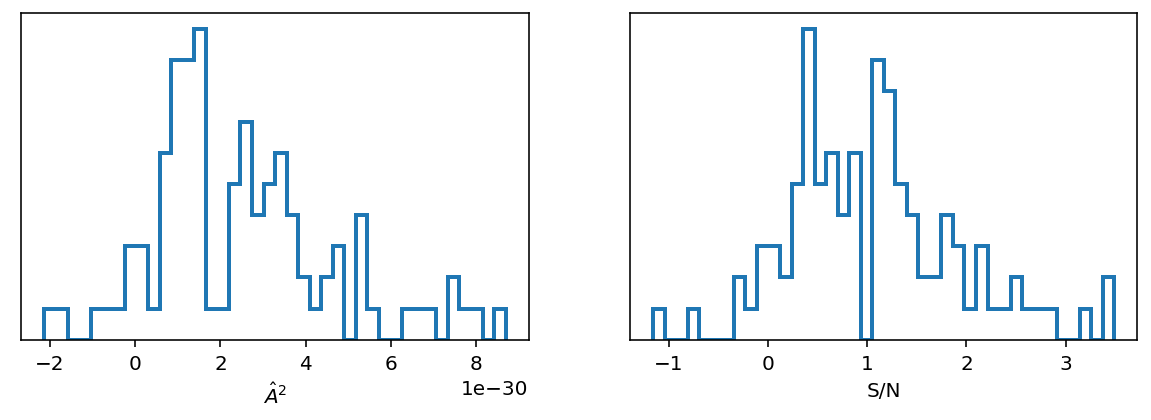

In [50]:
fig = plt.figure(figsize=[10,3])
fig.add_subplot(121)
plt.hist(Ahat,bins=40,histtype='step',lw=2)
plt.yticks([])
plt.xlabel('$\hat{A}^2$')

fig.add_subplot(122)
plt.hist(snr,bins=40,histtype='step',lw=2)
plt.xlabel('S/N')
plt.yticks([])

plt.show()

In [51]:
sky_idx = 10
scr_npz = np.load('./scrambles_ng15yr_p1.npz')
# thetas = scr_npz['thetas'][sky_idx,:]
# phis = scr_npz['phis'][sky_idx,:]
orfs = scr_npz['orfs']

In [52]:
N = 100
Ahat_scr = np.zeros(N)
snr_scr = np.zeros(N)
for ii in range(N):
    param_dict = {}
    idx = np.random.randint(burn,chain.shape[0])
    param_dict = dict(zip(pars,chain[idx,:-4]))
    _, _, _, Asqr, Sigma = os.compute_os(params=param_dict,orf=orfs[sky_idx,:])
    Ahat_scr[ii] = Asqr
    snr_scr[ii] = Asqr/Sigma
    if ii%100 == 0 and ii != 0:
        print(f'\r{ii/10}% complete.',end='',flush=True)

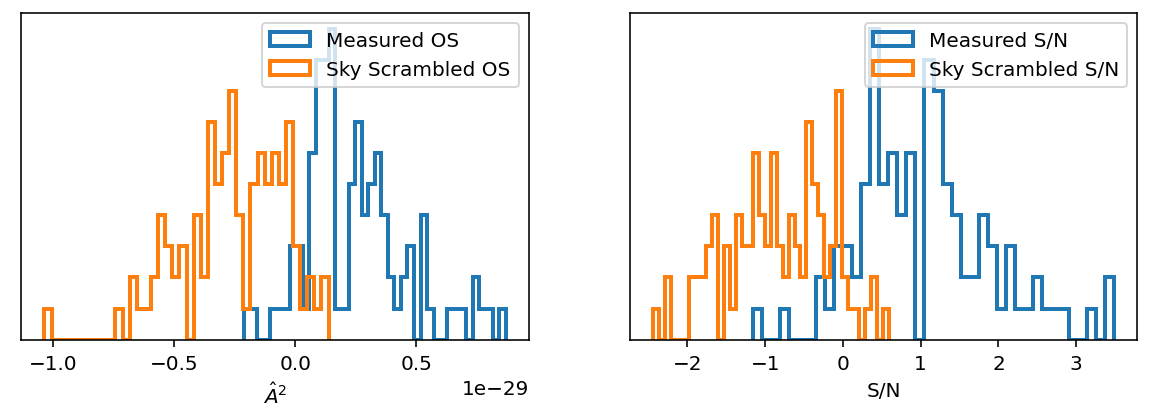

In [53]:
fig = plt.figure(figsize=[10,3])
fig.add_subplot(121)
plt.hist(Ahat,bins=40,histtype='step',label='Measured OS',lw=2)
# plt.hist(Ahat_pshift,bins=40,histtype='step',labeled='Phase Shifted OS',lw=2)
plt.hist(Ahat_scr,bins=40,histtype='step',label='Sky Scrambled OS',lw=2)
plt.yticks([])
plt.xlabel('$\hat{A}^2$')
plt.legend()

fig.add_subplot(122)
plt.hist(snr,bins=40,histtype='step',label='Measured S/N',lw=2)
# plt.hist(snr_pshift,bins=40,histtype='step',labeled='Phase Shifted S/N',lw=2)
plt.hist(snr_scr,bins=40,histtype='step',label='Sky Scrambled S/N',lw=2)
plt.xlabel('S/N')
plt.yticks([])
plt.legend()

plt.show()

In [ ]:
N = 100
M = orfs.shape[0]
Ahat_means = np.zeros(M)
snr_means = np.zeros(M)
for jj in range(M):
    Ahat_scr = np.zeros(N)
    snr_scr = np.zeros(N)
    for ii in range(N):
        param_dict = {}
        idx = np.random.randint(burn,chain.shape[0])
        param_dict = dict(zip(pars,chain[idx,:-4]))
        _, _, _, Asqr, Sigma = os.compute_os(params=param_dict,orf=orfs[jj,:])
        Ahat_scr[ii] = Asqr
        snr_scr[ii] = Asqr/Sigma
    if jj%100 == 0 and jj != 0:
        print(f'\r{jj/M*100}% complete.',end='',flush=True)
    Ahat_means[jj] = Ahat_scr.mean()
    snr_means[jj] = snr_scr.mean()

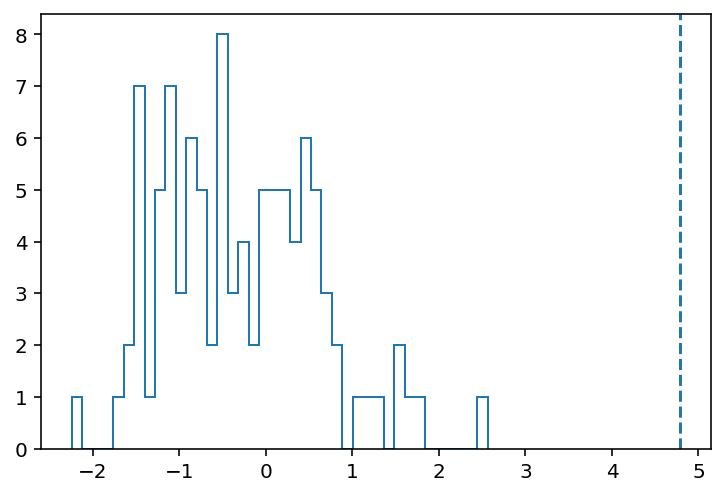

In [61]:
plt.hist(snr_means[:100],bins=40,histtype='step')
plt.axvline(snr.mean(),linestyle='--',color='C0')
plt.show()

In [57]:
orfs.shape[0]

9958

## Concatenate samples

In [4]:
psh1 = np.loadtxt('../../OS_pshift_means.txt')

In [20]:
psh2 = np.array([-0.44167265, -1.14021796,  1.47861872, -0.58794987, -0.44140566,  0.44816179,
                 -0.43911063,  2.03686454, -0.38333933, -1.33577721,  0.36896126, -0.09895134,
                 -0.04084579,  0.1380343,   0.53009188, -0.48472645, -0.71132573, -0.23749216,
                 -0.59874207, -0.03475382, -0.25079644, -1.28215087,  0.94576964, -0.64889173,
                 -1.4361845,   0.35557501,  0.09070242, -0.46205709, -0.81987374,  0.13301088,
                 -0.97860762, -1.39691185,  0.89504563, -0.8139356,   0.37395744,  0.66510833,
                  0.5545539,  -1.5653327,  0.05610045, -0.13513098,  0.444881,   -0.73733686,
                  0.78997618,  1.50958499, -0.85292833, -0.0047997,   0.18484413, -0.84691006,
                 -2.05127691,  0.64991957, -0.71230222,  0.81574525,  0.50703689,  0.23093926,
                  1.24148223,  1.0103059,   1.27977139, -0.35712141, -0.40973928,  0.56632395,
                  1.11478389,  0.37974008, -0.25107205,  0.28561284, -0.89868662, -0.4185295,
                  1.17292217,  0.01138537, -0.76936915, -0.13611132,  0.02211537,  0.6317044,
                  1.20039435,  0.94762409, -0.38975461,  0.01288668, -0.72684279,  0.40517739,
                 -0.78548819, -0.75612073,  0.31600638, -0.72049192,  0.89187863, -0.72486424,
                 -0.08569662,  1.19621733,  0.38970336, -0.13190081,  0.16785842,  0.51970621,
                 -1.53775543,  0.47865462, -0.55561337, -0.10445699,  0.60497808, -1.07129101,
                  0.70955068, -0.80477913, -0.56720564, -0.00579799]
                )

In [21]:
sk1 = np.loadtxt('../../OS_scramble_means.txt')

In [22]:
psh = np.concatenate([psh1,psh2])

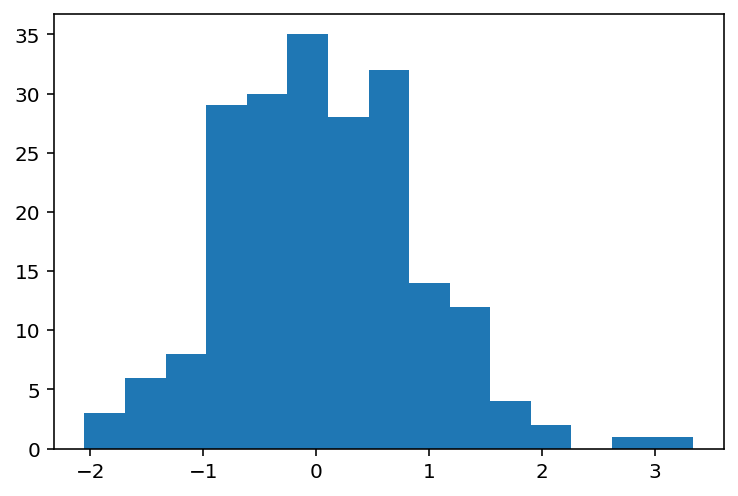

In [25]:
plt.hist(psh,bins=15)
plt.show()

In [18]:
np.argmax(psh2)

38

In [19]:
psh2[38]

5653327.0